# Synchronization(同步)
Синхронизация

Synchronization is a set of processing that occurs before demodulation and channel decoding.

同步，可以理解为在通信时、函数调用时、协议栈的相邻层协议交互时等场景下，发信方与收信方、主调与被调等双方的状态是否能及时保持状态一致。同步还可以理解为：发出一个调用时，在没有得到结果之前，该调用就不返回；一旦调用返回，就得到返回值。换句话说，就是由调用者主动等待这个调用的结果。而异步则是相反，调用在发出之后，这个调用就直接返回了，所以没有返回结果。当一个异步过程调用发出后，调用者不会立刻得到结果。而是在调用发出后，被调用者通过状态、通知或通过回调函数，让调用者能响应结果。

![title](1.png)

Before we learn how to implement time and frequency synchronization, we need to make our simulated signals more realistic. Without adding some random time delay, the act of synchronizing in time is trivial. In fact, you only need to take into account the sample delay of any filters you use. We also want to simulate a frequency offset because, as we will discuss, oscillators are not perfect; there will always be some offset between the transmitter and receiver’s center frequency.同步之前，需要添加一些随机时间延迟使模拟信号更真实。实际上只需要考虑滤波器的采样延迟。另外，还需要模拟频率偏移(振荡器不完美，发射器与接收器的中心频率之间有偏移)。

Python Code from Pulse Shaping

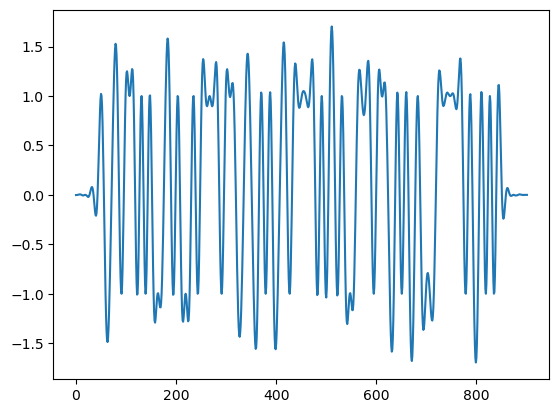

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import math

num_symbols = 100
sps = 8
bits = np.random.randint(0, 2, num_symbols) # Our data to be transmitted, 1's and 0's
pulse_train = np.array([])
for bit in bits:
    pulse = np.zeros(sps)
    pulse[0] = bit*2-1 # set the first value to either a 1 or -1
    pulse_train = np.concatenate((pulse_train, pulse)) # add the 8 samples to the signal

# Create our raised-cosine filter
num_taps = 101
beta = 0.35
Ts = sps # Assume sample rate is 1 Hz, so sample period is 1, so *symbol* period is 8
t = np.arange(-51, 52) # remember it's not inclusive of final number
h = np.sinc(t/Ts) * np.cos(np.pi*beta*t/Ts) / (1 - (2*beta*t/Ts)**2)

# Filter our signal, in order to apply the pulse shaping
samples = np.convolve(pulse_train, h)
plt.plot(samples)

Adding a Delay(添加延迟)

 We can simulate the delay of a fraction of a sample by making a “fractional delay” filter, which passes all frequencies but delays the samples by some amount that isn’t limited to the sample interval. You can think of it as an all-pass filter that applies the same phase shift to all frequencies. (Recall that a time delay and phase shift are equivalent.)可以制作一个“分数延迟”滤波器来模拟部分延迟。可以视为对所有频率应用相同相移的全通滤波器(时延=相移)

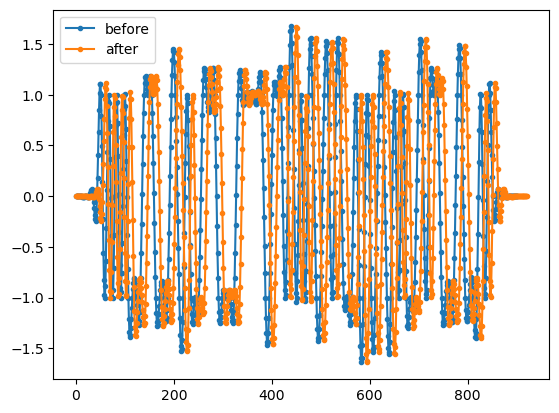

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import math

num_symbols = 100
sps = 8
bits = np.random.randint(0, 2, num_symbols) # Our data to be transmitted, 1's and 0's
pulse_train = np.array([])
for bit in bits:
    pulse = np.zeros(sps)
    pulse[0] = bit*2-1 # set the first value to either a 1 or -1
    pulse_train = np.concatenate((pulse_train, pulse)) # add the 8 samples to the signal

# Create our raised-cosine filter
num_taps = 101
beta = 0.35
Ts = sps # Assume sample rate is 1 Hz, so sample period is 1, so *symbol* period is 8
t = np.arange(-51, 52) # remember it's not inclusive of final number
h = np.sinc(t/Ts) * np.cos(np.pi*beta*t/Ts) / (1 - (2*beta*t/Ts)**2)

# Filter our signal, in order to apply the pulse shaping
samples = np.convolve(pulse_train, h)
plt.plot(samples,'.-')
# Create and apply fractional delay filter
delay = 0.4 # fractional delay, in samples
N = 21 # number of taps
n = np.arange(-N//2, N//2) # ...-3,-2,-1,0,1,2,3...
h = np.sinc(n - delay) # calc filter taps
h *= np.hamming(N) # window the filter to make sure it decays to 0 on both sides
h /= np.sum(h) # normalize to get unity gain, we don't want to change the amplitude/power
samples = np.convolve(samples, h) # apply filter
plt.plot(samples,'.-')
plt.legend(['before','after'])
plt.show()

Adding a Frequency Offset(添加频率偏移)

To make our simulated signal more realistic, we will apply a frequency offset. Let’s say that our sample rate in this simulation is 1 MHz. If we want to simulate a frequency offset of 13 kHz (some arbitrary number), we can do it via the following code:假设模拟中采样率为1MHz，如果想模拟13kHz的频率偏移

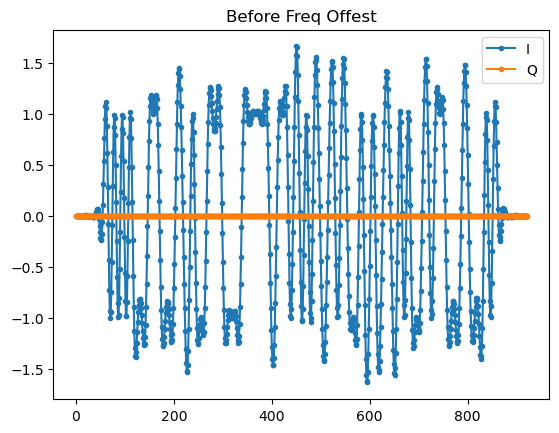

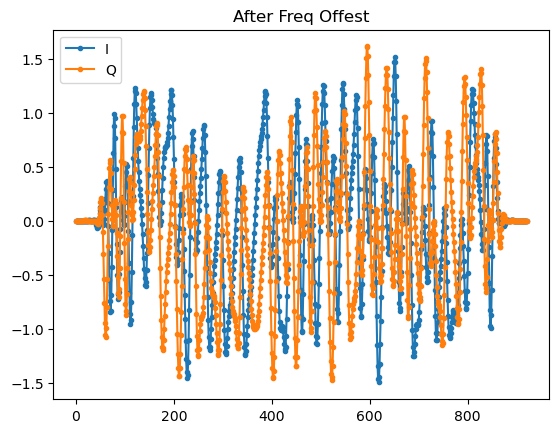

In [3]:
plt.figure(0)
plt.plot(np.real(samples),'.-')
plt.plot(np.imag(samples),'.-')
plt.legend(['I','Q'])
plt.title('Before Freq Offest')
# apply a freq offset
fs = 1e6 # assume our sample rate is 1 MHz
fo = 13000 # simulate freq offset
Ts = 1/fs # calc sample period
t = np.arange(0, Ts*len(samples), Ts) # create time vector
samples = samples * np.exp(1j*2*np.pi*fo*t) # perform freq shift
plt.figure(1)
plt.plot(np.real(samples),'.-')
plt.plot(np.imag(samples),'.-')
plt.legend(['I','Q'])
plt.title('After Freq Offest')
plt.show()

# Time Synchronization

When we transmit a signal wirelessly, it arrives at the receiver with a random phase shift due to time traveled. We cannot just start sampling the symbols at our symbol rate because we are unlikely to sample it at the right spot in the pulse.
信号无线传输时，由于时间延迟，接收器处具有随机相移。由于不太可能在脉冲中的正确位置对其进行采样，所以不能仅以符号率对其进行采样。

You can picture timing recovery as a block in the receiver, which accepts a stream of samples and outputs another stream of samples (similar to a filter). We program this timing recovery block with information about our signal, the most important being the number of samples per symbol (or our best guess at it, if we are not 100% sure what was transmitted). This block acts as a “decimator”, i.e., our sample output will be a fraction of the number of samples in. We want one sample per digital symbol, so the decimation rate is simply the samples per symbol. If the transmitter transmits at 1M symbols per second, and we sample at 16 Msps, we will receive 16 samples per symbol. That will be the sample rate going into the timing sync block. The sample rate coming out of the block will be 1 Msps because we want one sample per digital symbol.
可以把时序恢复想象成一个块，它接收一个流并输出一个流(类似过滤器)。利用信号的信息对该时序恢复块进行编程。该块充当“抽取器”，即样本输出将是样本输入的一小部分。我们希望每个数字符号有一个样本，因此抽取率就是每个符号的样本数。如果发射器以每秒1M符号的速度传输，并且我们以16Msps的速率进行采样，那么每个符号将接收到16个样本。这将是进入定时同步块的采样率。来自模块的采样率将为1Msps，因为我们希望每个数字符号一个样本。

The following Python code implements the Mueller and Muller clock recovery technique.

D:\anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17848\2220717305.py:5: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  out = np.zeros(len(samples) + 10, dtype=np.complex)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17848\2220717305.py:6: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.

Text(0.5, 1.0, 'Output of the symbol synchronizer')

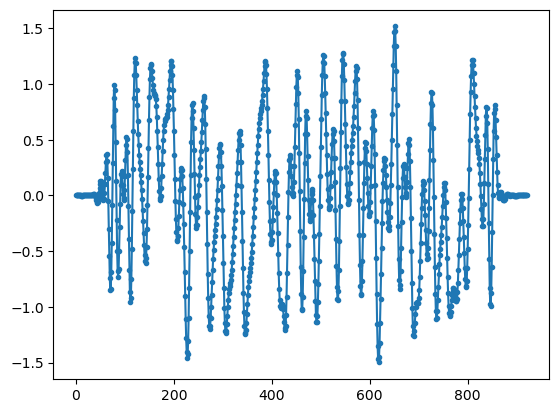

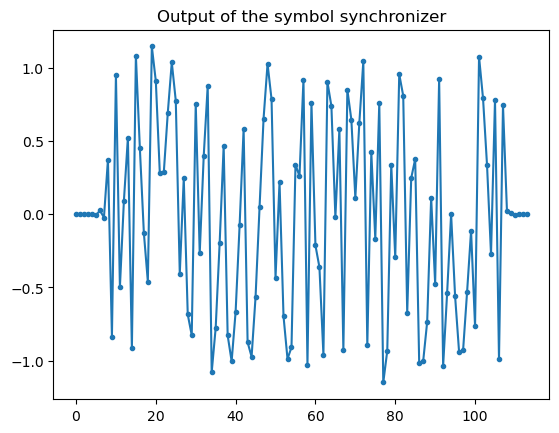

In [4]:
plt.figure(0)
plt.plot(samples,'.-')

mu = 0 # initial estimate of phase of sample
out = np.zeros(len(samples) + 10, dtype=np.complex)
out_rail = np.zeros(len(samples) + 10, dtype=np.complex) # stores values, each iteration we need the previous 2 values plus current value
i_in = 0 # input samples index
i_out = 2 # output index (let first two outputs be 0)
while i_out < len(samples) and i_in+16 < len(samples):
    out[i_out] = samples[i_in + int(mu)] # grab what we think is the "best" sample
    out_rail[i_out] = int(np.real(out[i_out]) > 0) + 1j*int(np.imag(out[i_out]) > 0)
    x = (out_rail[i_out] - out_rail[i_out-2]) * np.conj(out[i_out-1])
    y = (out[i_out] - out[i_out-2]) * np.conj(out_rail[i_out-1])
    mm_val = np.real(y - x)
    mu += sps + 0.3*mm_val
    i_in += int(np.floor(mu)) # round down to nearest int since we are using it as an index
    mu = mu - np.floor(mu) # remove the integer part of mu
    i_out += 1 # increment output index
out = out[2:i_out] # remove the first two, and anything after i_out (that was never filled out)
samples = out # only include this line if you want to connect this code snippet with the Costas Loop later on
plt.figure(1)
plt.plot(samples,'.-')
plt.title('Output of the symbol synchronizer')

It helps that this example didn’t have any noise added. Feel free to add noise or time shifts and see how the synchronizer behaves. If we were using QPSK then we would be dealing with complex numbers, but the approach would be the same.

# Time Synchronization with Interpolation(带插值的时间同步)
Синхронизация времени с интерполяцией

Symbol synchronizers tend to interpolate the input samples by some number, e.g., 16, so that it’s able to shift by a fraction of a sample. The random delay caused by the wireless channel will unlikely be an exact multiple of a sample, so the peak of the symbol may not actually happen on a sample. It is especially true in a case where there might only be 2 or 4 samples per symbol being received. By interpolating the samples, it gives us the ability to sample “in between” actual samples, in order to hit the very peak of each symbol. The output of the synchronizer is still only 1 sample per symbol. The input samples themselves are interpolated.
通过对样本进行插值，它使我们能够在实际样本“之间”进行采样，一边达到每个符号的峰值。同步器的输出仍然使每个符号一个样本。输入样本本身被插值。

A quick way to interpolate a signal in Python is to use signal.resample_poly.Let’s interpolate by 16 (this is arbitrarily chose, you can try different values), i.e., we will be inserting 15 extra samples between each sample. It can be done in one line of code, and it should happen before we go to perform time synchronization. Let’s also plot the before and after to see the difference:插值16，即在每个样本之间插入15个额外样本

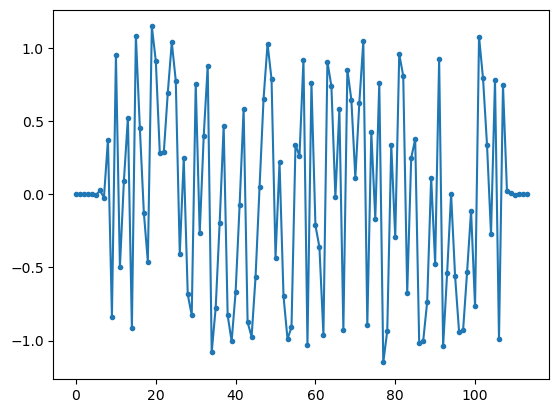

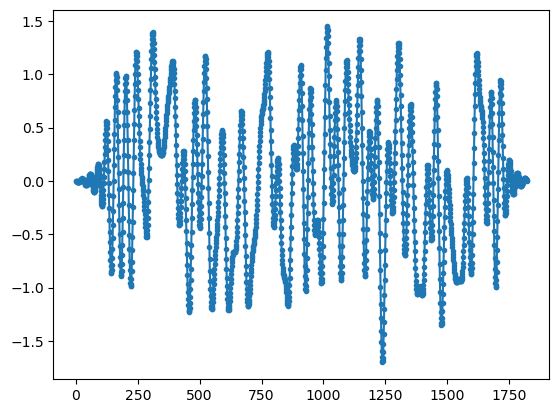

In [7]:
samples_interpolated = signal.resample_poly(samples, 16, 1)

# Plot the old vs new
plt.figure('before interp')
plt.plot(samples,'.-')
plt.figure('after interp')
plt.plot(samples_interpolated,'.-')
plt.show()

# Frequency synchronization频率同步

Even though we tell the transmitter and receiver to operate on the same center frequency, there is going to be a slight frequency offset between the two due to either imperfections in hardware (e.g., the oscillator) or a Doppler shift from movement. This frequency offset will be tiny relative to the carrier frequency, but even a small offset can throw off a digital signal. The offset will likely change over time, necessitating an always-running feedback loop to correct the offset.We must remove any frequency offsets before demodulation.

即使告诉发射器和接收器在中心频率上运行，由于硬件(例如振荡器)缺陷或有传输引起的多普勒频移，两者之间仍会存在轻微的频率偏移。虽然该频率偏移对于载波频率来说很小，但也会影响数字信号。偏移量可能会随着时间而改变，所以需要一个始终运行的反馈回路来纠正偏移量。我们必须在解调之前去除任何频率偏移

Frequency synchronization is usually broken down into coarse sync and fine sync, where coarse corrects large offsets on the order of kHz or more, while the fine sync corrects whatever is left. Coarse happens before time sync, while fine happens after.

频率同步分为粗同步和细同步，粗同步矫正kHz或更大量级的偏移，细同步矫正剩余内容。粗同步在时间同步之前，细同步在时间同步之后。

粗同步(coarse sync/грубая синхронизация)

![title](2.png)

Let’s see what happens when we take the square of our signal s(t) by considering what QPSK would do. Squaring complex numbers leads to interesting behavior, especially when we are talking about constellations like BPSK and QPSK. The following animation shows what happens when you square QPSK, then square it again. I specifically used QPSK instead of BPSK because you can see that when you square QPSK once, you essentially get BPSK. And then after one more square it becomes one cluster.

%%html
<img src="https://pysdr.org/_images/squaring-qpsk.gif">

对信号平方。上图显示了对QPSK进行平方，得到BPSK，然后再次平方，得到一簇。

Let’s watch what happens when our QPSK signal has a small phase rotation and magnitude scaling applied to it, which is more realistic:

对QPSK信号应用小的相位旋转和幅度缩放

%%html
<img src="https://pysdr.org/_images/squaring-qpsk2.gif">

It still becomes one cluster, just with a phase shift. The main take-away here is that if you square QPSK twice (and BPSK once), it will merge all four clusters of points into one cluster.By merging the clusters we are essentially removing the modulation!

它仍会成为带有相移的一簇。如果对QPSK进行两次平方(对BPSK进行一次平方)，四个点簇会合并为一个。通过合并集群，消除了调制。

![title](3.png)

 ![title](4.png)

First look at the signal before squaring (just a normal FFT):

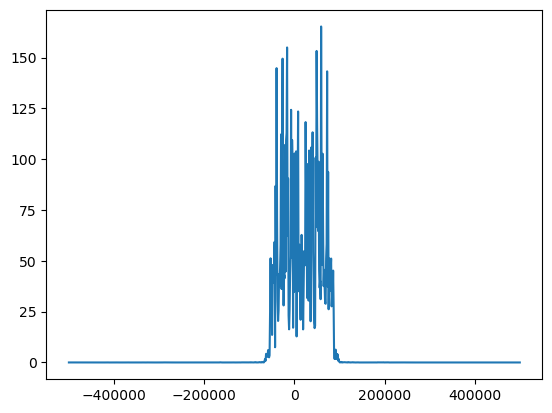

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import math

num_symbols = 100
sps = 8
bits = np.random.randint(0, 2, num_symbols) # Our data to be transmitted, 1's and 0's
pulse_train = np.array([])
for bit in bits:
    pulse = np.zeros(sps)
    pulse[0] = bit*2-1 # set the first value to either a 1 or -1
    pulse_train = np.concatenate((pulse_train, pulse)) # add the 8 samples to the signal

# Create our raised-cosine filter
num_taps = 101
beta = 0.35
Ts = sps # Assume sample rate is 1 Hz, so sample period is 1, so *symbol* period is 8
t = np.arange(-51, 52) # remember it's not inclusive of final number
h = np.sinc(t/Ts) * np.cos(np.pi*beta*t/Ts) / (1 - (2*beta*t/Ts)**2)

# Filter our signal, in order to apply the pulse shaping
samples = np.convolve(pulse_train, h)
fs = 1e6 # assume our sample rate is 1 MHz
fo = 16000 # simulate freq offset=16
Ts = 1/fs # calc sample period
t = np.arange(0, Ts*len(samples), Ts) # create time vector
samples = samples * np.exp(1j*2*np.pi*fo*t) # perform freq shift
psd = np.fft.fftshift(np.abs(np.fft.fft(samples)))
f = np.linspace(-fs/2.0, fs/2.0, len(psd))
N = len(samples)
plt.plot(f, psd)
plt.show()

смещение частоты=16kHz

We don’t actually see any peak associated with the carrier offset. It’s covered up by our signal.这里看不到与载波偏移相关的峰值，它被信号掩盖了。

Now with the squaring added (just a power of 2 because it’s BPSK):
现在加上平方(BPSK)

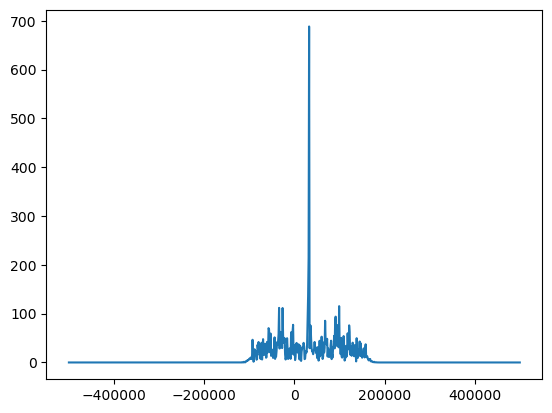

In [9]:
# Add this before the FFT line
samples = samples**2
psd = np.fft.fftshift(np.abs(np.fft.fft(samples)))
f = np.linspace(-fs/2.0, fs/2.0, len(psd))
plt.plot(f, psd)
plt.show()



[]

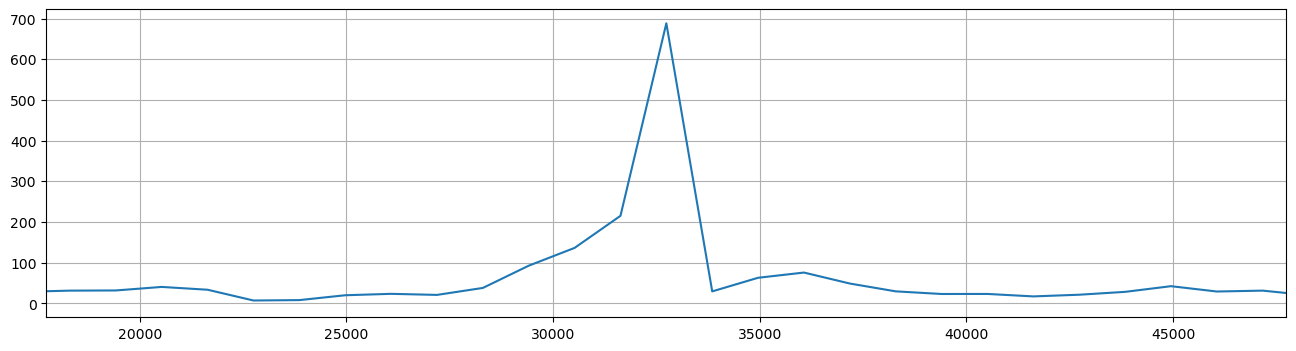

In [10]:
max_freq = f[np.argmax(psd)]
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(f, psd)
ax.set_xlim([max_freq-15000, max_freq+15000])
ax.grid(True)
plt.plot()

carrier offset = 32741.398

The offset frequency spike shows up at Nfo. We need to divide this bin (32.74 kHz) by 2 to find our final answer, which is very close to the 16 kHz frequency offset we applied at the beginning of the chapter!
偏移频率尖峰出现在Nfo,32.7kHz除以2接近开始应用的16kHz频率偏移。

精细频率同步(Fine Frequency Synchronization)

For fine frequency sync we will want a feedback loop that we stream samples through, which once again will be a form of PLL. Our goal is to get the frequency offset to zero and maintain it there, even if the offset changes over time. We have to continuously track the offset. Fine frequency sync techniques work best with a signal that already has been synchronized in time at the symbol level, so the code we discuss in this section will come after timing sync.
对于精细频率同步，需要一个反馈回路，目标是使频率偏移为0并保持为0。必须持续跟踪偏移量。精细频率偏移同步技术最适用于已在符号级别及时同步的信号，因此它在时间同步之后进行。

# PLLs

![title](8.png)

![title](9.png)

# Costas Loop

We will use a technique called a Costas Loop. It is a form of PLL that is specifically designed for carrier frequency offset correction for digital signals like BPSK and QPSK.使用Costas Loop技术，它是PLL的一种形式，专门为BPSK和QPSK等数字信号的载波频率偏移矫正而设计

The Costas Loop will remove the frequency offset while also fixing any phase offset. The energy is aligned with the I axis. Frequency is just a change in phase so they can be tracked as one. The Costas Loop is summarized using the following diagram
Costas Loop将消除频率偏移，同时修复任何相位偏移。能量与I轴对齐，频率只是相位的变化，因此可以对它们进行追踪。


![title](7.png)

![title](10.png)

![title](11.png)

# Early Late Symbol Sync

![title](12.png)

# Frame sync帧同步
Синхронизация кадров

![title](13.png)

![title](14.png)